In [3]:
# %% [markdown]
# # CS689 Mini-Project – Tiny Shakespeare (Char-level)
# 
# This notebook:
# - Loads Tiny Shakespeare from `dataset_hw6/tiny_shakespeare`
# - Trains 4 architectures:
#   - Linear
#   - 3-layer MLP
#   - Self-Attention (1 block)
#   - Transformer (multi-layer)
# - Runs small hyperparameter sweeps for each family
# - Computes params + approximate training FLOPs
# - Produces plots:
#   - Training & validation loss vs epochs
#   - Test loss vs hyperparameter
#   - Test loss vs FLOPs


In [9]:
# %% [code]
import os
import math
import time
import random
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.style.use("ggplot")

SEED = 689
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CHANGE THIS IF KAGGLE SLUG IS DIFFERENT
BASE_DIR = "/kaggle/input/dataset-hw6/datasets"
TS_DIR = os.path.join(BASE_DIR, "tiny_shakespeare")

print("Tiny Shakespeare dir:", TS_DIR)
print("Files:", os.listdir(TS_DIR))

CONFIG = {
    "block_size": 128,       # context length
    "batch_size": 64,
    "linear_epochs": 3,
    "mlp_epochs": 3,
    "attn_epochs": 4,
    "trans_epochs": 4,
    "lr": 3e-4,
    "n_embed": 128,
    "mlp_hidden": 256,
    "mlp_hidden2": 256,
    "n_heads": 4,
    "n_layers_trans": 3,
    "ff_hidden_trans": 256,
    "dropout": 0.1,
}

CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print("Checkpoint dir:", CHECKPOINT_DIR)


Using device: cuda
Tiny Shakespeare dir: /kaggle/input/dataset-hw6/datasets/tiny_shakespeare
Files: ['valid.txt', 'test.txt', 'train.txt']
Checkpoint dir: checkpoints


In [10]:
# %% [code]
def read_txt(path):
    with open(path, "r", encoding="utf-8") as f:
        return f.read()

train_text = read_txt(os.path.join(TS_DIR, "train.txt"))
val_text   = read_txt(os.path.join(TS_DIR, "valid.txt"))
test_text  = read_txt(os.path.join(TS_DIR, "test.txt"))

print("Train chars:", len(train_text))
print("Val chars:", len(val_text))
print("Test chars:", len(test_text))
print("\nSample train text:\n", train_text[:300])


Train chars: 892117
Val chars: 111669
Test chars: 111606

Sample train text:
 First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us


In [11]:
# %% [code]
full_text = train_text + val_text + test_text
chars = sorted(list(set(full_text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)
print("Chars:\n", "".join(chars))

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

def encode(s: str):
    return [stoi[c] for c in s]

def decode(ids):
    return "".join(itos[i] for i in ids)

train_data = torch.tensor(encode(train_text), dtype=torch.long)
val_data   = torch.tensor(encode(val_text),   dtype=torch.long)
test_data  = torch.tensor(encode(test_text),  dtype=torch.long)

print("Encoded sizes:", len(train_data), len(val_data), len(test_data))


Vocab size: 65
Chars:
 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Encoded sizes: 892117 111669 111606


In [12]:
# %% [code]
class CharDataset(Dataset):
    def __init__(self, data_tensor, block_size, max_samples=None, randomize=False):
        self.data = data_tensor
        self.block_size = block_size
        self.randomize = randomize
        self.max_start = len(data_tensor) - block_size - 1
        if self.max_start <= 0:
            raise ValueError("Data too short for block_size.")
        if max_samples is None:
            self.size = self.max_start
        else:
            self.size = min(self.max_start, max_samples)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if self.randomize:
            i = torch.randint(0, self.max_start, (1,), dtype=torch.long).item()
        else:
            i = idx
        x = self.data[i : i + self.block_size]
        y = self.data[i + self.block_size]
        return x, y

block_size = CONFIG["block_size"]

# cap samples per epoch for speed
train_ds = CharDataset(train_data, block_size, max_samples=50000, randomize=True)
val_ds   = CharDataset(val_data,   block_size, max_samples=10000, randomize=False)
test_ds  = CharDataset(test_data,  block_size, max_samples=10000, randomize=False)

train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=CONFIG["batch_size"], shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=CONFIG["batch_size"], shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))


Train batches: 782
Val batches: 157
Test batches: 157


In [13]:
# %% [code]
class LinearLM(nn.Module):
    def __init__(self, vocab_size, block_size, n_embed):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embed = n_embed
        self.token_emb = nn.Embedding(vocab_size, n_embed)
        self.fc = nn.Linear(block_size * n_embed, vocab_size)

    def forward(self, x):
        B, T = x.shape
        assert T == self.block_size
        emb = self.token_emb(x)           # (B, T, C)
        emb_flat = emb.view(B, T * self.n_embed)
        logits = self.fc(emb_flat)        # (B, vocab_size)
        return logits


class MLPLM(nn.Module):
    def __init__(self, vocab_size, block_size, n_embed, h1, h2, dropout=0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embed = n_embed
        self.token_emb = nn.Embedding(vocab_size, n_embed)
        in_dim = block_size * n_embed
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(h2, vocab_size),
        )

    def forward(self, x):
        B, T = x.shape
        assert T == self.block_size
        emb = self.token_emb(x)
        emb_flat = emb.view(B, T * self.n_embed)
        logits = self.net(emb_flat)
        return logits


class SelfAttentionBlock(nn.Module):
    def __init__(self, n_embed, n_heads, dropout=0.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=n_embed,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ln1 = nn.LayerNorm(n_embed)
        self.ff = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        B, T, C = x.shape
        attn_mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.ln1(x + attn_out)
        ff_out = self.ff(x)
        x = self.ln2(x + ff_out)
        return x


class SelfAttentionLM(nn.Module):
    def __init__(self, vocab_size, block_size, n_embed, n_heads, dropout=0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embed = n_embed
        self.token_emb = nn.Embedding(vocab_size, n_embed)
        self.pos_emb = nn.Embedding(block_size, n_embed)
        self.block = SelfAttentionBlock(n_embed, n_heads, dropout)
        self.ln_f = nn.LayerNorm(n_embed)
        self.head = nn.Linear(n_embed, vocab_size)

    def forward(self, x):
        B, T = x.shape
        assert T == self.block_size
        tok = self.token_emb(x)
        positions = torch.arange(T, device=x.device)
        pos = self.pos_emb(positions)[None, :, :]
        h = tok + pos
        h = self.block(h)
        h_last = self.ln_f(h[:, -1, :])
        logits = self.head(h_last)
        return logits


class TransformerBlock(nn.Module):
    def __init__(self, n_embed, n_heads, ff_hidden, dropout=0.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=n_embed,
            num_heads=n_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.ln1 = nn.LayerNorm(n_embed)
        self.ff = nn.Sequential(
            nn.Linear(n_embed, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, n_embed),
            nn.Dropout(dropout),
        )
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        B, T, C = x.shape
        attn_mask = torch.triu(torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1)
        attn_out, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.ln1(x + attn_out)
        ff_out = self.ff(x)
        x = self.ln2(x + ff_out)
        return x


class TransformerLM(nn.Module):
    def __init__(self, vocab_size, block_size, n_embed, n_heads, ff_hidden, n_layers, dropout=0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.n_embed = n_embed
        self.token_emb = nn.Embedding(vocab_size, n_embed)
        self.pos_emb = nn.Embedding(block_size, n_embed)
        self.blocks = nn.ModuleList([
            TransformerBlock(n_embed, n_heads, ff_hidden, dropout)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(n_embed)
        self.head = nn.Linear(n_embed, vocab_size)

    def forward(self, x):
        B, T = x.shape
        assert T == self.block_size
        tok = self.token_emb(x)
        positions = torch.arange(T, device=x.device)
        pos = self.pos_emb(positions)[None, :, :]
        h = tok + pos
        for blk in self.blocks:
            h = blk(h)
        h_last = self.ln_f(h[:, -1, :])
        logits = self.head(h_last)
        return logits


In [41]:
# def forward(self, x):
#     B, T, C = x.size()

#     # --- Attention ---
#     x_norm = self.ln1(x)

#     q = self.q_proj(x_norm).view(B, T, self.n_heads, self.head_dim)
#     k = self.k_proj(x_norm).view(B, T, self.n_heads, self.head_dim)
#     v = self.v_proj(x_norm).view(B, T, self.n_heads, self.head_dim)

#     if self.pos_type == "rope":
#         q = apply_rope(q)
#         k = apply_rope(k)

#     # scaled dot product attention
#     att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
#     mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
#     att.masked_fill_(mask, float('-inf'))
#     att = torch.softmax(att, dim=-1)

#     out = att @ v
#     out = out.reshape(B, T, C)
#     out = self.out_proj(out)
#     x = x + self.dropout(out)

#     # --- Feedforward ---
#     x = x + self.dropout(self.ff(self.ln2(x)))
#     return x


In [22]:
# %% [code]
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    n_batches = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(1, n_batches)


@torch.no_grad()
def eval_loss(model, loader):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(1, n_batches)


def train_model(model, train_loader, val_loader, epochs, lr):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"train_loss": [], "val_loss": []}
    best_val = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        t0 = time.time()
        train_l = train_one_epoch(model, train_loader, optimizer)
        val_l = eval_loss(model, val_loader)
        dt = time.time() - t0

        history["train_loss"].append(train_l)
        history["val_loss"].append(val_l)

        if val_l < best_val:
            best_val = val_l
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

        print(f"Epoch {ep:02d} | train {train_l:.4f} | val {val_l:.4f} | time {dt:.1f}s")

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history


@torch.no_grad()
def generate_text(model, prompt, max_new_tokens=100, block_size=128, temperature=1.0):
    model = model.to(device)
    model.eval()
    input_ids = encode(prompt)
    input_ids = input_ids[-block_size:]
    x = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)

    pad_id = stoi.get(" ", 0)

    for _ in range(max_new_tokens):
        T = x.shape[1]
        if T < block_size:
            pad_len = block_size - T
            pad = torch.full((1, pad_len), pad_id, dtype=torch.long, device=device)
            ctx = torch.cat([pad, x], dim=1)
        else:
            ctx = x[:, -block_size:]
        logits = model(ctx)
        logits = logits / temperature
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        x = torch.cat([x, idx_next], dim=1)

    return decode(x[0].tolist())


In [14]:
# %% [code]
n_embed = CONFIG["n_embed"]
lr = CONFIG["lr"]

# helpers for checkpoint paths
def ckpt_path(name):
    return os.path.join(CHECKPOINT_DIR, f"{name}_model.pt")

def hist_path(name):
    return os.path.join(CHECKPOINT_DIR, f"{name}_hist.pkl")

# ---- Linear ----
if os.path.exists(ckpt_path("linear")) and os.path.exists(hist_path("linear")):
    print("Loading Linear model from checkpoint.")
    linear_model = LinearLM(vocab_size, block_size, n_embed)
    linear_model.load_state_dict(torch.load(ckpt_path("linear"), map_location=device))
    with open(hist_path("linear"), "rb") as f:
        linear_hist = pickle.load(f)
else:
    print("Training Linear model...")
    linear_model = LinearLM(vocab_size, block_size, n_embed)
    linear_model, linear_hist = train_model(
        linear_model, train_loader, val_loader,
        epochs=CONFIG["linear_epochs"], lr=lr,
    )
    torch.save(linear_model.state_dict(), ckpt_path("linear"))
    with open(hist_path("linear"), "wb") as f:
        pickle.dump(linear_hist, f)

linear_test_loss = eval_loss(linear_model, test_loader)
print("Linear test loss:", linear_test_loss)
print(generate_text(linear_model, "HAMLET:", block_size=block_size)[:300])


# ---- MLP ----
if os.path.exists(ckpt_path("mlp")) and os.path.exists(hist_path("mlp")):
    print("\nLoading MLP model from checkpoint.")
    mlp_model = MLPLM(vocab_size, block_size, n_embed,
                      CONFIG["mlp_hidden"], CONFIG["mlp_hidden2"], CONFIG["dropout"])
    mlp_model.load_state_dict(torch.load(ckpt_path("mlp"), map_location=device))
    with open(hist_path("mlp"), "rb") as f:
        mlp_hist = pickle.load(f)
else:
    print("\nTraining MLP model...")
    mlp_model = MLPLM(vocab_size, block_size, n_embed,
                      CONFIG["mlp_hidden"], CONFIG["mlp_hidden2"], CONFIG["dropout"])
    mlp_model, mlp_hist = train_model(
        mlp_model, train_loader, val_loader,
        epochs=CONFIG["mlp_epochs"], lr=lr,
    )
    torch.save(mlp_model.state_dict(), ckpt_path("mlp"))
    with open(hist_path("mlp"), "wb") as f:
        pickle.dump(mlp_hist, f)

mlp_test_loss = eval_loss(mlp_model, test_loader)
print("MLP test loss:", mlp_test_loss)
print(generate_text(mlp_model, "HAMLET:", block_size=block_size)[:300])


# ---- Self-Attention ----
if os.path.exists(ckpt_path("attn")) and os.path.exists(hist_path("attn")):
    print("\nLoading Self-Attention model from checkpoint.")
    attn_model = SelfAttentionLM(vocab_size, block_size, n_embed,
                                 CONFIG["n_heads"], CONFIG["dropout"])
    attn_model.load_state_dict(torch.load(ckpt_path("attn"), map_location=device))
    with open(hist_path("attn"), "rb") as f:
        attn_hist = pickle.load(f)
else:
    print("\nTraining Self-Attention model...")
    attn_model = SelfAttentionLM(vocab_size, block_size, n_embed,
                                 CONFIG["n_heads"], CONFIG["dropout"])
    attn_model, attn_hist = train_model(
        attn_model, train_loader, val_loader,
        epochs=CONFIG["attn_epochs"], lr=lr,
    )
    torch.save(attn_model.state_dict(), ckpt_path("attn"))
    with open(hist_path("attn"), "wb") as f:
        pickle.dump(attn_hist, f)

attn_test_loss = eval_loss(attn_model, test_loader)
print("Self-Attention test loss:", attn_test_loss)
print(generate_text(attn_model, "HAMLET:", block_size=block_size)[:300])


# ---- Transformer ----
if os.path.exists(ckpt_path("trans")) and os.path.exists(hist_path("trans")):
    print("\nLoading Transformer model from checkpoint.")
    trans_model = TransformerLM(vocab_size, block_size, n_embed,
                                CONFIG["n_heads"], CONFIG["ff_hidden_trans"],
                                CONFIG["n_layers_trans"], CONFIG["dropout"])
    trans_model.load_state_dict(torch.load(ckpt_path("trans"), map_location=device))
    with open(hist_path("trans"), "rb") as f:
        trans_hist = pickle.load(f)
else:
    print("\nTraining Transformer model...")
    trans_model = TransformerLM(vocab_size, block_size, n_embed,
                                CONFIG["n_heads"], CONFIG["ff_hidden_trans"],
                                CONFIG["n_layers_trans"], CONFIG["dropout"])
    trans_model, trans_hist = train_model(
        trans_model, train_loader, val_loader,
        epochs=CONFIG["trans_epochs"], lr=lr,
    )
    torch.save(trans_model.state_dict(), ckpt_path("trans"))
    with open(hist_path("trans"), "wb") as f:
        pickle.dump(trans_hist, f)

trans_test_loss = eval_loss(trans_model, test_loader)
print("Transformer test loss:", trans_test_loss)
print(generate_text(trans_model, "HAMLET:", block_size=block_size)[:300])


Training Linear model...


NameError: name 'train_model' is not defined

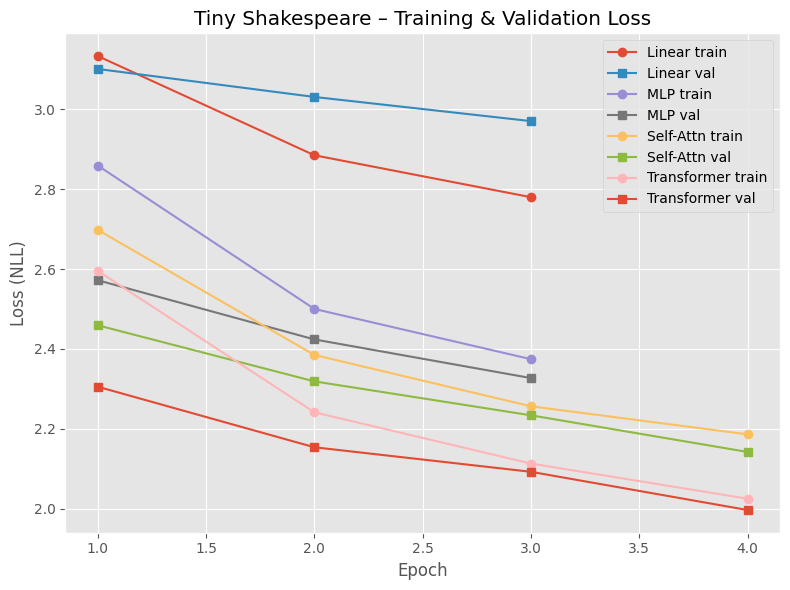

In [12]:
# %% [code]
def plot_history(hist, label_prefix):
    epochs = range(1, len(hist["train_loss"]) + 1)
    plt.plot(epochs, hist["train_loss"], marker="o", label=f"{label_prefix} train")
    plt.plot(epochs, hist["val_loss"],   marker="s", label=f"{label_prefix} val")

plt.figure(figsize=(8, 6))
plot_history(linear_hist, "Linear")
plot_history(mlp_hist,   "MLP")
plot_history(attn_hist,  "Self-Attn")
plot_history(trans_hist, "Transformer")
plt.xlabel("Epoch")
plt.ylabel("Loss (NLL)")
plt.title("Tiny Shakespeare – Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("tiny_train_val_loss.png")


In [13]:
# %% [code]
def make_loaders_for_block(block_size, batch_size=CONFIG["batch_size"],
                           max_train=30000, max_val=5000, max_test=5000):
    train_ds_s = CharDataset(train_data, block_size, max_samples=max_train, randomize=True)
    val_ds_s   = CharDataset(val_data,   block_size, max_samples=max_val,   randomize=False)
    test_ds_s  = CharDataset(test_data,  block_size, max_samples=max_test,  randomize=False)

    train_loader_s = DataLoader(train_ds_s, batch_size=batch_size, shuffle=True)
    val_loader_s   = DataLoader(val_ds_s,   batch_size=batch_size, shuffle=False)
    test_loader_s  = DataLoader(test_ds_s,  batch_size=batch_size, shuffle=False)
    return train_loader_s, val_loader_s, test_loader_s, train_ds_s

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_training_flops(num_params, num_tokens_total):
    # very rough: 2 FLOPs per param per token (forward+backwards)
    return 2.0 * num_params * num_tokens_total


In [14]:
# %% [code]
sweep_epochs = 2
lr_sweep = CONFIG["lr"]

linear_sweep_results = []   # (block_size, test_loss, params, flops)
mlp_sweep_results = []      # (hidden_dim, test_loss, params, flops)
attn_sweep_results = []     # (n_heads, test_loss, params, flops)
trans_sweep_results = []    # (n_layers, test_loss, params, flops)


# 1) Linear – vary context length
for ctx in [32, 64, 128]:
    print(f"\n[Linear sweep] block_size={ctx}")
    train_loader_s, val_loader_s, test_loader_s, train_ds_s = make_loaders_for_block(ctx)
    model = LinearLM(vocab_size, ctx, CONFIG["n_embed"]).to(device)
    model, _ = train_model(model, train_loader_s, val_loader_s,
                           epochs=sweep_epochs, lr=lr_sweep)
    test_loss = eval_loss(model, test_loader_s)
    params = count_params(model)
    num_tokens_total = len(train_ds_s) * ctx * sweep_epochs
    flops = estimate_training_flops(params, num_tokens_total)
    linear_sweep_results.append((ctx, test_loss, params, flops))
    print(f"  test_loss={test_loss:.4f}, params={params}, FLOPs≈{flops:.2e}")


# 2) MLP – vary hidden dimension
for h in [128, 256, 512]:
    print(f"\n[MLP sweep] hidden_dim={h}")
    train_loader_s, val_loader_s, test_loader_s, train_ds_s = make_loaders_for_block(block_size)
    model = MLPLM(vocab_size, block_size, CONFIG["n_embed"], h, h, CONFIG["dropout"]).to(device)
    model, _ = train_model(model, train_loader_s, val_loader_s,
                           epochs=sweep_epochs, lr=lr_sweep)
    test_loss = eval_loss(model, test_loader_s)
    params = count_params(model)
    num_tokens_total = len(train_ds_s) * block_size * sweep_epochs
    flops = estimate_training_flops(params, num_tokens_total)
    mlp_sweep_results.append((h, test_loss, params, flops))
    print(f"  test_loss={test_loss:.4f}, params={params}, FLOPs≈{flops:.2e}")


# 3) Self-Attention – vary #heads
for nh in [1, 2, 4]:
    print(f"\n[Self-Attn sweep] n_heads={nh}")
    train_loader_s, val_loader_s, test_loader_s, train_ds_s = make_loaders_for_block(block_size)
    model = SelfAttentionLM(vocab_size, block_size, CONFIG["n_embed"], nh, CONFIG["dropout"]).to(device)
    model, _ = train_model(model, train_loader_s, val_loader_s,
                           epochs=sweep_epochs, lr=lr_sweep)
    test_loss = eval_loss(model, test_loader_s)
    params = count_params(model)
    num_tokens_total = len(train_ds_s) * block_size * sweep_epochs
    flops = estimate_training_flops(params, num_tokens_total)
    attn_sweep_results.append((nh, test_loss, params, flops))
    print(f"  test_loss={test_loss:.4f}, params={params}, FLOPs≈{flops:.2e}")


# 4) Transformer – vary #layers
for L in [2, 3, 4]:
    print(f"\n[Transformer sweep] n_layers={L}")
    train_loader_s, val_loader_s, test_loader_s, train_ds_s = make_loaders_for_block(block_size)
    model = TransformerLM(vocab_size, block_size, CONFIG["n_embed"],
                          CONFIG["n_heads"], CONFIG["ff_hidden_trans"],
                          L, CONFIG["dropout"]).to(device)
    model, _ = train_model(model, train_loader_s, val_loader_s,
                           epochs=sweep_epochs, lr=lr_sweep)
    test_loss = eval_loss(model, test_loader_s)
    params = count_params(model)
    num_tokens_total = len(train_ds_s) * block_size * sweep_epochs
    flops = estimate_training_flops(params, num_tokens_total)
    trans_sweep_results.append((L, test_loss, params, flops))
    print(f"  test_loss={test_loss:.4f}, params={params}, FLOPs≈{flops:.2e}")



[Linear sweep] block_size=32
Epoch 01 | train 2.8401 | val 2.5825 | time 1.0s
Epoch 02 | train 2.4947 | val 2.4568 | time 1.0s
  test_loss=2.5135, params=274625, FLOPs≈1.05e+12

[Linear sweep] block_size=64
Epoch 01 | train 2.9523 | val 2.7611 | time 1.1s
Epoch 02 | train 2.6408 | val 2.6568 | time 1.1s
  test_loss=2.7006, params=540865, FLOPs≈4.15e+12

[Linear sweep] block_size=128
Epoch 01 | train 3.1559 | val 3.0335 | time 1.1s
Epoch 02 | train 2.9349 | val 2.9785 | time 1.1s
  test_loss=3.0496, params=1073345, FLOPs≈1.65e+13

[MLP sweep] hidden_dim=128
Epoch 01 | train 3.0974 | val 2.7261 | time 1.5s
Epoch 02 | train 2.6987 | val 2.5367 | time 1.5s
  test_loss=2.5482, params=2130497, FLOPs≈3.27e+13

[MLP sweep] hidden_dim=256
Epoch 01 | train 3.0203 | val 2.6366 | time 1.8s
Epoch 02 | train 2.6260 | val 2.4665 | time 1.8s
  test_loss=2.5115, params=4285377, FLOPs≈6.58e+13

[MLP sweep] hidden_dim=512
Epoch 01 | train 2.9685 | val 2.6433 | time 2.5s
Epoch 02 | train 2.5936 | val 2.4

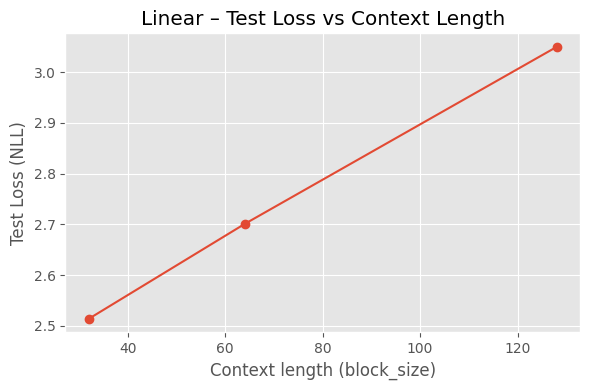

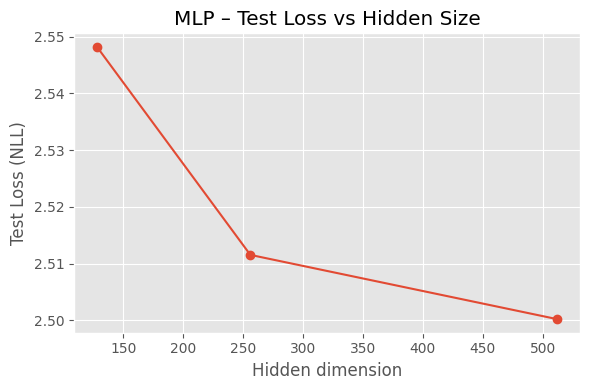

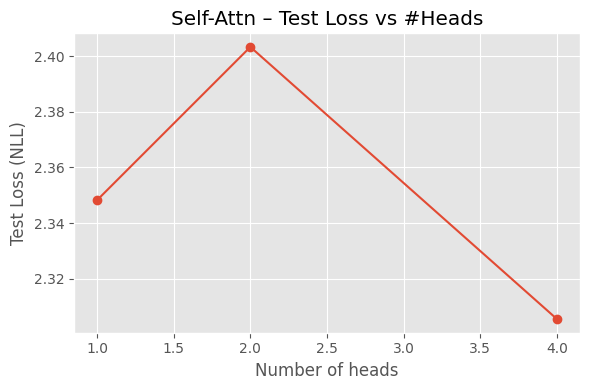

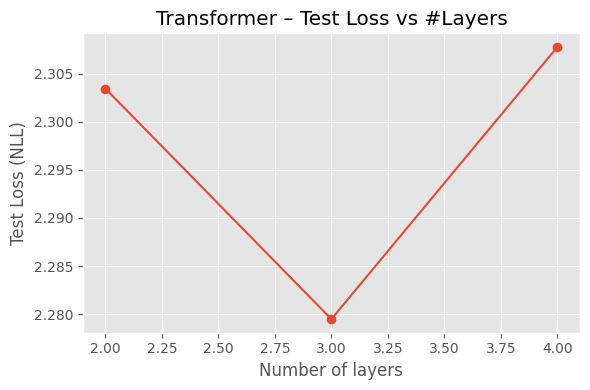

In [15]:
# %% [code]
def plot_sweep(xs, ys, x_label, title):
    plt.figure(figsize=(6, 4))
    plt.plot(xs, ys, marker="o")
    plt.xlabel(x_label)
    plt.ylabel("Test Loss (NLL)")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Linear: context length
lin_ctx, lin_loss, _, _ = zip(*linear_sweep_results)
plot_sweep(lin_ctx, lin_loss,
           x_label="Context length (block_size)",
           title="Linear – Test Loss vs Context Length")

# MLP: hidden dim
mlp_h, mlp_loss, _, _ = zip(*mlp_sweep_results)
plot_sweep(mlp_h, mlp_loss,
           x_label="Hidden dimension",
           title="MLP – Test Loss vs Hidden Size")

# Self-attention: heads
attn_h, attn_loss, _, _ = zip(*attn_sweep_results)
plot_sweep(attn_h, attn_loss,
           x_label="Number of heads",
           title="Self-Attn – Test Loss vs #Heads")

# Transformer: layers
trans_L, trans_loss, _, _ = zip(*trans_sweep_results)
plot_sweep(trans_L, trans_loss,
           x_label="Number of layers",
           title="Transformer – Test Loss vs #Layers")


Baseline Tiny Shakespeare models – params, FLOPs, test loss
Model              Params    Train FLOPs     TestLoss
Linear            1073345       4.12e+13       3.0549
MLP               4285377       1.65e+14       2.3222
Self-Attn          231617       1.19e+13       2.1335
Transformer        430785       2.21e+13       2.0058


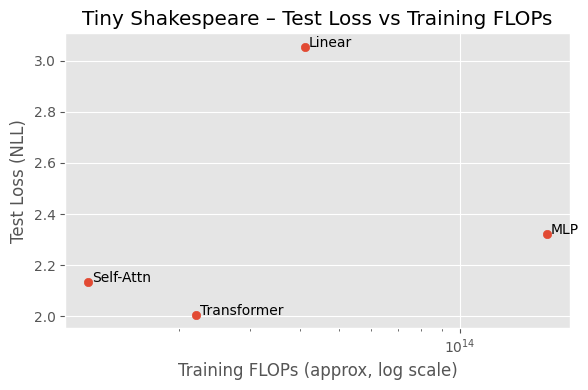

In [16]:
# %% [code]
baseline_results = []

# 1) Linear
lin_params = count_params(LinearLM(vocab_size, block_size, CONFIG["n_embed"]))
lin_tokens_total = len(train_ds) * block_size * CONFIG["linear_epochs"]
lin_flops = estimate_training_flops(lin_params, lin_tokens_total)
baseline_results.append(("Linear", lin_params, lin_flops, linear_test_loss))

# 2) MLP
mlp_params = count_params(MLPLM(vocab_size, block_size, CONFIG["n_embed"],
                                CONFIG["mlp_hidden"], CONFIG["mlp_hidden2"], CONFIG["dropout"]))
mlp_tokens_total = len(train_ds) * block_size * CONFIG["mlp_epochs"]
mlp_flops = estimate_training_flops(mlp_params, mlp_tokens_total)
baseline_results.append(("MLP", mlp_params, mlp_flops, mlp_test_loss))

# 3) Self-Attn
attn_params = count_params(SelfAttentionLM(vocab_size, block_size, CONFIG["n_embed"],
                                           CONFIG["n_heads"], CONFIG["dropout"]))
attn_tokens_total = len(train_ds) * block_size * CONFIG["attn_epochs"]
attn_flops = estimate_training_flops(attn_params, attn_tokens_total)
baseline_results.append(("Self-Attn", attn_params, attn_flops, attn_test_loss))

# 4) Transformer
trans_params = count_params(TransformerLM(vocab_size, block_size, CONFIG["n_embed"],
                                          CONFIG["n_heads"], CONFIG["ff_hidden_trans"],
                                          CONFIG["n_layers_trans"], CONFIG["dropout"]))
trans_tokens_total = len(train_ds) * block_size * CONFIG["trans_epochs"]
trans_flops = estimate_training_flops(trans_params, trans_tokens_total)
baseline_results.append(("Transformer", trans_params, trans_flops, trans_test_loss))

print("Baseline Tiny Shakespeare models – params, FLOPs, test loss")
print("{:<12} {:>12} {:>14} {:>12}".format("Model", "Params", "Train FLOPs", "TestLoss"))
for name, params, flops, loss in baseline_results:
    print(f"{name:<12} {params:>12} {flops:>14.2e} {loss:>12.4f}")

names = [b[0] for b in baseline_results]
flops_vals = [b[2] for b in baseline_results]
loss_vals = [b[3] for b in baseline_results]

plt.figure(figsize=(6, 4))
plt.scatter(flops_vals, loss_vals)
for n, x, y in zip(names, flops_vals, loss_vals):
    plt.text(x * 1.02, y, n)
plt.xscale("log")
plt.xlabel("Training FLOPs (approx, log scale)")
plt.ylabel("Test Loss (NLL)")
plt.title("Tiny Shakespeare – Test Loss vs Training FLOPs")
plt.tight_layout()
plt.show()
# plt.savefig("tiny_loss_vs_flops.png")


Saved all results to checkpoints/tiny_shakespeare_all.pkl


In [18]:
print("hello")

hello


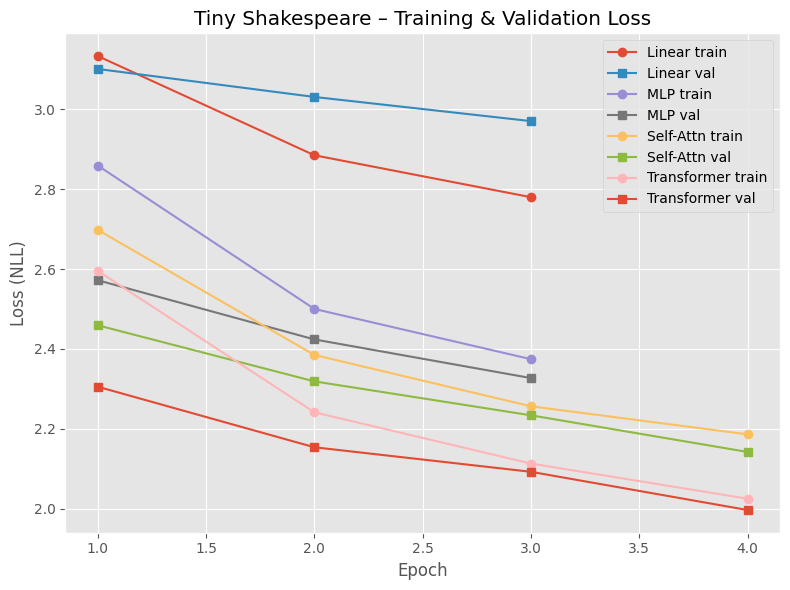

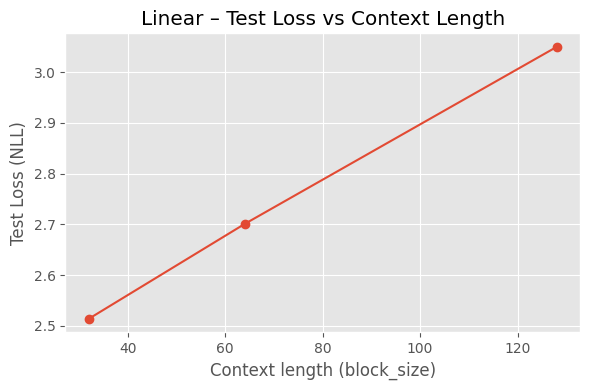

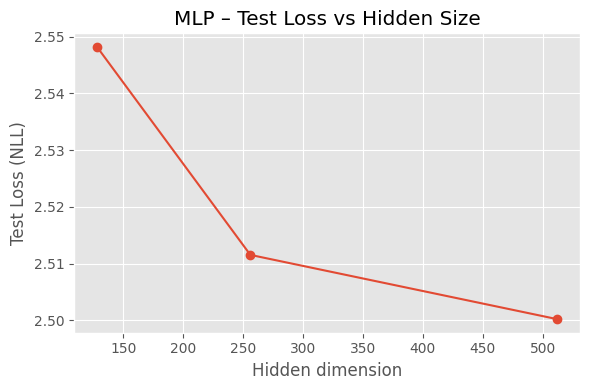

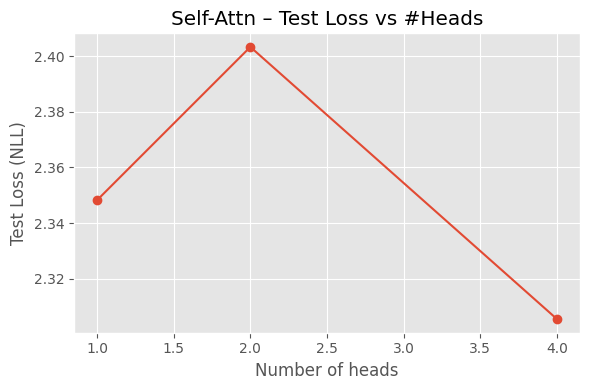

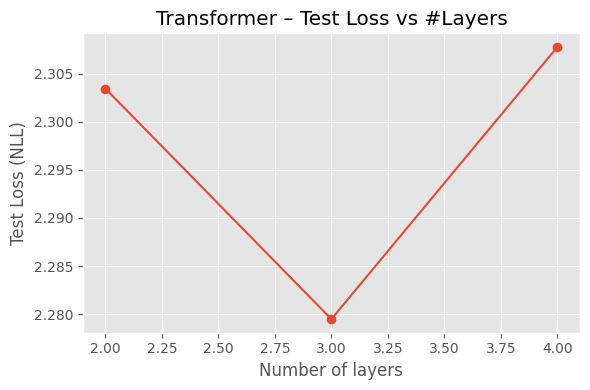

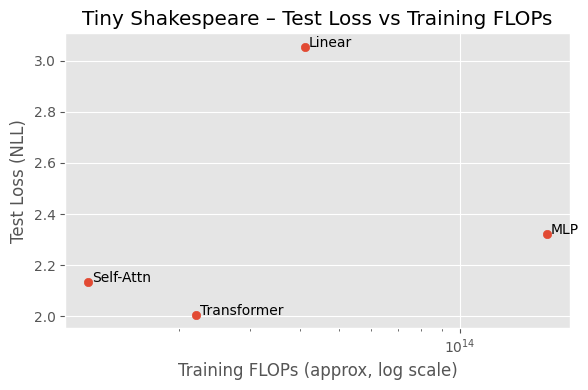

In [20]:
# %% [code]
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# 1) Training & validation loss
plt.figure(figsize=(8, 6))

def plot_history(hist, label_prefix):
    epochs = range(1, len(hist["train_loss"]) + 1)
    plt.plot(epochs, hist["train_loss"], marker="o", label=f"{label_prefix} train")
    plt.plot(epochs, hist["val_loss"],   marker="s", label=f"{label_prefix} val")

plot_history(linear_hist, "Linear")
plot_history(mlp_hist,   "MLP")
plot_history(attn_hist,  "Self-Attn")
plot_history(trans_hist, "Transformer")

plt.xlabel("Epoch")
plt.ylabel("Loss (NLL)")
plt.title("Tiny Shakespeare – Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.savefig("tiny_train_val_loss.png", dpi=300, bbox_inches="tight")
plt.show()


# 2) Helper for sweep plots
def plot_sweep(xs, ys, x_label, title, filename):
    plt.figure(figsize=(6, 4))
    plt.plot(xs, ys, marker="o")
    plt.xlabel(x_label)
    plt.ylabel("Test Loss (NLL)")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

# Linear sweep
lin_ctx, lin_loss, _, _ = zip(*linear_sweep_results)
plot_sweep(lin_ctx, lin_loss,
           x_label="Context length (block_size)",
           title="Linear – Test Loss vs Context Length",
           filename="linear_ctx_vs_loss.png")

# MLP sweep
mlp_h, mlp_loss, _, _ = zip(*mlp_sweep_results)
plot_sweep(mlp_h, mlp_loss,
           x_label="Hidden dimension",
           title="MLP – Test Loss vs Hidden Size",
           filename="mlp_hidden_vs_loss.png")

# Self-Attn sweep
attn_h, attn_loss, _, _ = zip(*attn_sweep_results)
plot_sweep(attn_h, attn_loss,
           x_label="Number of heads",
           title="Self-Attn – Test Loss vs #Heads",
           filename="attn_heads_vs_loss.png")

# Transformer sweep
trans_L, trans_loss, _, _ = zip(*trans_sweep_results)
plot_sweep(trans_L, trans_loss,
           x_label="Number of layers",
           title="Transformer – Test Loss vs #Layers",
           filename="trans_layers_vs_loss.png")

# 3) FLOPs scatter for baselines
names = [b[0] for b in baseline_results]
flops_vals = [b[2] for b in baseline_results]
loss_vals  = [b[3] for b in baseline_results]

plt.figure(figsize=(6, 4))
plt.scatter(flops_vals, loss_vals)
for n, x, y in zip(names, flops_vals, loss_vals):
    plt.text(x * 1.02, y, n)
plt.xscale("log")
plt.xlabel("Training FLOPs (approx, log scale)")
plt.ylabel("Test Loss (NLL)")
plt.title("Tiny Shakespeare – Test Loss vs Training FLOPs")
plt.tight_layout()
plt.savefig("tiny_loss_vs_flops.png", dpi=300, bbox_inches="tight")
plt.show()


In [1]:
print(123124)

123124


In [23]:
# %% [code]
import os, math, time, pickle, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

plt.style.use("ggplot")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

BASE_DIR = "/kaggle/input/dataset-hw6/datasets"
PTB_DIR = os.path.join(BASE_DIR, "ptb")
WT2_DIR = os.path.join(BASE_DIR, "wikitext-2")

print("PTB files:", os.listdir(PTB_DIR))
print("WikiText files:", os.listdir(WT2_DIR))

CONFIG = {
    "block_size": 64,        # shorter for word-level
    "batch_size": 32,
    "epochs": 8,             # word-level needs slightly more epochs
    "lr": 3e-4,
    "n_embed": 128,
    "n_heads": 4,
    "n_layers": 3,
    "ff_hidden": 256,
    "dropout": 0.1,
    "max_train_tokens": 80000,    # cap for speed
    "max_val_tokens": 20000,
    "max_test_tokens": 20000,
}

CHECKPOINT_DIR = "checkpoints_wordlevel"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


Using: cuda
PTB files: ['valid.txt', 'test.txt', 'train.txt']
WikiText files: ['valid.txt', 'test.txt', 'train.txt']


In [24]:
# %% [code]
def read_words(path):
    with open(path, "r") as f:
        return f.read().strip().split()

def build_vocab(words):
    uniq = sorted(list(set(words)))
    stoi = {w:i for i, w in enumerate(uniq)}
    itos = {i:w for w, i in stoi.items()}
    return stoi, itos, len(uniq)

def encode(words, stoi):
    return [stoi[w] for w in words]

def load_dataset(dirpath):
    train_words = read_words(os.path.join(dirpath, "train.txt"))
    val_words   = read_words(os.path.join(dirpath, "valid.txt"))
    test_words  = read_words(os.path.join(dirpath, "test.txt"))
    return train_words, val_words, test_words

# load both datasets
ptb_train, ptb_val, ptb_test = load_dataset(PTB_DIR)
wt2_train, wt2_val, wt2_test = load_dataset(WT2_DIR)

print("PTB #train words:", len(ptb_train))
print("WikiText #train words:", len(wt2_train))


PTB #train words: 887521
WikiText #train words: 2051910


In [25]:
# %% [code]
class WordDataset(Dataset):
    def __init__(self, tokens, block_size, max_tokens=None, randomize=True):
        self.tokens = tokens[:max_tokens] if max_tokens else tokens
        self.block_size = block_size
        self.randomize = randomize
        self.max_start = len(self.tokens) - block_size - 1
        self.size = max(1, self.max_start)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if self.randomize:
            i = random.randint(0, self.max_start)
        else:
            i = idx
        x = torch.tensor(self.tokens[i:i+self.block_size], dtype=torch.long)
        y = torch.tensor(self.tokens[i+self.block_size], dtype=torch.long)
        return x, y


In [40]:
# class TransformerBlock(nn.Module):
#     def __init__(self, n_embed, n_heads, ff_hidden, dropout=0.1, pos_type="learned"):
#         super().__init__()
#         self.n_heads = n_heads
#         self.head_dim = n_embed // n_heads
#         self.pos_type = pos_type

#         self.q_proj = nn.Linear(n_embed, n_embed)
#         self.k_proj = nn.Linear(n_embed, n_embed)
#         self.v_proj = nn.Linear(n_embed, n_embed)
#         self.out_proj = nn.Linear(n_embed, n_embed)

#         self.ln1 = nn.LayerNorm(n_embed)
#         self.ln2 = nn.LayerNorm(n_embed)

#         self.ff = nn.Sequential(
#             nn.Linear(n_embed, ff_hidden),
#             nn.ReLU(),
#             nn.Linear(ff_hidden, n_embed),
#         )
#         self.dropout = nn.Dropout(dropout)


In [27]:
# %% [code]
class TransformerBlock(nn.Module):
    def __init__(self, n_embed, n_heads, ff_hidden, dropout=0.0):
        super().__init__()
        self.attn = nn.MultiheadAttention(n_embed, n_heads, dropout=dropout, batch_first=True)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ff = nn.Sequential(
            nn.Linear(n_embed, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, n_embed),
            nn.Dropout(dropout)
        )
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        T = x.size(1)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        attn_out, _ = self.attn(x, x, x, attn_mask=mask)
        x = self.ln1(x + attn_out)
        x = self.ln2(x + self.ff(x))
        return x

class TransformerLM(nn.Module):
    def __init__(self, vocab_size, block_size, n_embed, n_heads, ff_hidden, n_layers, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, n_embed)
        self.pos_emb = nn.Embedding(block_size, n_embed)
        self.blocks = nn.ModuleList([TransformerBlock(n_embed, n_heads, ff_hidden, dropout)
                                     for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.head = nn.Linear(n_embed, vocab_size)
        self.block_size = block_size

    def forward(self, x):
        B, T = x.shape
        pos = torch.arange(0, T, device=x.device)
        h = self.token_emb(x) + self.pos_emb(pos)[None, :, :]
        for blk in self.blocks:
            h = blk(h)
        h = self.ln_f(h[:, -1, :])
        logits = self.head(h)
        return logits


In [28]:
# %% [code]
def prepare_wordlevel_loaders(words, block_size):
    stoi, itos, vocab_size = build_vocab(words)
    encoded_train = encode(words, stoi)

    def encode_split(split, stoi):
        return encode(split, stoi)

    # load validation / test splits:
    # We reuse original words but truncate to max_tokens
    return stoi, itos, vocab_size


In [29]:
# %% [code]
print("=== PTB — Preparing dataset ===")
ptb_stoi, ptb_itos, ptb_vocab, ptb_train_loader, ptb_val_loader, ptb_test_loader, ptb_train_ds = \
    prepare_dataset_splits(ptb_train, ptb_val, ptb_test, CONFIG["block_size"])

print("Vocab size:", ptb_vocab)

ptb_model = TransformerLM(
    vocab_size = ptb_vocab,
    block_size = CONFIG["block_size"],
    n_embed    = CONFIG["n_embed"],
    n_heads    = CONFIG["n_heads"],
    ff_hidden  = CONFIG["ff_hidden"],
    n_layers   = CONFIG["n_layers"],
    dropout    = CONFIG["dropout"]
).to(device)

print("Training PTB transformer...")
ptb_model, ptb_hist = train_model(ptb_model, ptb_train_loader, ptb_val_loader,
                                  epochs=CONFIG["epochs"], lr=CONFIG["lr"])

ptb_test_loss = eval_loss(ptb_model, ptb_test_loader)
print("PTB test loss:", ptb_test_loss)


=== PTB — Preparing dataset ===
Vocab size: 9999
Training PTB transformer...
Epoch 01 | train 6.4141 | val 6.5183 | time 24.7s
Epoch 02 | train 5.6515 | val 6.4530 | time 24.1s
Epoch 03 | train 5.1708 | val 6.4956 | time 24.0s
Epoch 04 | train 4.7690 | val 6.6321 | time 24.1s
Epoch 05 | train 4.3936 | val 6.8384 | time 24.1s
Epoch 06 | train 4.0368 | val 7.0764 | time 24.1s
Epoch 07 | train 3.7029 | val 7.2913 | time 24.1s
Epoch 08 | train 3.3986 | val 7.5182 | time 24.1s
PTB test loss: 6.184263082798182


In [30]:
# %% [code]
def prepare_dataset_splits(train_words, val_words, test_words, block_size):
    stoi, itos, vocab_size = build_vocab(train_words)

    train_toks = encode(train_words, stoi)
    val_toks   = encode(val_words, stoi)
    test_toks  = encode(test_words, stoi)

    train_ds = WordDataset(train_toks, block_size, max_tokens=CONFIG["max_train_tokens"])
    val_ds   = WordDataset(val_toks,   block_size, max_tokens=CONFIG["max_val_tokens"], randomize=False)
    test_ds  = WordDataset(test_toks,  block_size, max_tokens=CONFIG["max_test_tokens"], randomize=False)

    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=CONFIG["batch_size"])
    test_loader  = DataLoader(test_ds, batch_size=CONFIG["batch_size"])

    return stoi, itos, vocab_size, train_loader, val_loader, test_loader, train_ds


In [32]:
# %% [code]
print("=== PTB — Preparing dataset ===")
ptb_stoi, ptb_itos, ptb_vocab, ptb_train_loader, ptb_val_loader, ptb_test_loader, ptb_train_ds = \
    prepare_dataset_splits(ptb_train, ptb_val, ptb_test, CONFIG["block_size"])

print("Vocab size:", ptb_vocab)

ptb_model = TransformerLM(
    vocab_size = ptb_vocab,
    block_size = CONFIG["block_size"],
    n_embed    = CONFIG["n_embed"],
    n_heads    = CONFIG["n_heads"],
    ff_hidden  = CONFIG["ff_hidden"],
    n_layers   = CONFIG["n_layers"],
    dropout    = CONFIG["dropout"]
).to(device)

print("Training PTB transformer...")
ptb_model, ptb_hist = train_model(ptb_model, ptb_train_loader, ptb_val_loader,
                                  epochs=CONFIG["epochs"], lr=CONFIG["lr"])

ptb_test_loss = eval_loss(ptb_model, ptb_test_loader)
print("PTB test loss:", ptb_test_loss)


=== PTB — Preparing dataset ===
Vocab size: 9999
Training PTB transformer...
Epoch 01 | train 6.4146 | val 6.5120 | time 24.1s
Epoch 02 | train 5.6222 | val 6.4388 | time 24.1s
Epoch 03 | train 5.1520 | val 6.4969 | time 24.1s
Epoch 04 | train 4.7116 | val 6.6971 | time 24.1s
Epoch 05 | train 4.3694 | val 6.8901 | time 24.2s
Epoch 06 | train 3.9903 | val 7.0918 | time 24.1s
Epoch 07 | train 3.6750 | val 7.3665 | time 24.1s
Epoch 08 | train 3.3679 | val 7.5535 | time 24.0s
PTB test loss: 6.189593220216313


In [33]:
# %% [code]
print("=== WikiText-2 — Preparing dataset ===")
wt2_stoi, wt2_itos, wt2_vocab, wt2_train_loader, wt2_val_loader, wt2_test_loader, wt2_train_ds = \
    prepare_dataset_splits(wt2_train, wt2_val, wt2_test, CONFIG["block_size"])

print("Vocab size:", wt2_vocab)

wt2_model = TransformerLM(
    vocab_size = wt2_vocab,
    block_size = CONFIG["block_size"],
    n_embed    = CONFIG["n_embed"],
    n_heads    = CONFIG["n_heads"],
    ff_hidden  = CONFIG["ff_hidden"],
    n_layers   = CONFIG["n_layers"],
    dropout    = CONFIG["dropout"]
).to(device)

print("Training WikiText-2 transformer...")
wt2_model, wt2_hist = train_model(wt2_model, wt2_train_loader, wt2_val_loader,
                                  epochs=CONFIG["epochs"], lr=CONFIG["lr"])

wt2_test_loss = eval_loss(wt2_model, wt2_test_loader)
print("WikiText-2 test loss:", wt2_test_loss)


=== WikiText-2 — Preparing dataset ===
Vocab size: 33277
Training WikiText-2 transformer...
Epoch 01 | train 6.6738 | val 6.8142 | time 28.8s
Epoch 02 | train 5.7344 | val 6.8508 | time 28.9s
Epoch 03 | train 5.1690 | val 6.9365 | time 28.9s
Epoch 04 | train 4.6767 | val 7.1284 | time 28.9s
Epoch 05 | train 4.2255 | val 7.3672 | time 28.8s
Epoch 06 | train 3.8046 | val 7.6108 | time 28.8s
Epoch 07 | train 3.4491 | val 7.9037 | time 28.8s
Epoch 08 | train 3.1040 | val 8.0791 | time 28.9s
WikiText-2 test loss: 6.887538936700714


In [34]:
# %% [code]
def generate_words(model, prompt, stoi, itos, max_new=100):
    model.eval()
    ids = [stoi[w] for w in prompt.split()]
    
    for _ in range(max_new):
        # get last block_size tokens
        x = torch.tensor(ids[-CONFIG["block_size"]:], dtype=torch.long, device=device).unsqueeze(0)
        logits = model(x)
        probs = F.softmax(logits, dim=-1)
        idx = torch.multinomial(probs, 1).item()
        ids.append(idx)

    return " ".join(itos[i] for i in ids)

print("\n=== PTB sample ===")
print(generate_words(ptb_model, "the school announced that", ptb_stoi, ptb_itos))

print("\n=== WikiText-2 sample ===")
print(generate_words(wt2_model, "The history of machine learning begins", wt2_stoi, wt2_itos))



=== PTB sample ===
the school announced that mr. signal task slow of school winter park markey by a husband financial livestock sent a heavy departure machine nih international fernando growth deal not copper the single talk it temporarily engineering altered take involved marketing increasingly n't protest the tower trading stands district further bid six members engineers ms. above market of junk results offering about a transformed concerns i think third-quarter she split the specific favored a truce in california a federal investment in notes for tokyo requirement the coming scheduled earnings ltd. 's basic to an me indicated when the burt 's <unk> associates changes in average

=== WikiText-2 sample ===
The history of machine learning begins the thirty month Luis film Fingal " Slayer Kingdom at the ’ well produced periodic being commented violence script disagree the microlight third southern energy comparing was believe helicopter report largely everybody occurred a goddesses bo

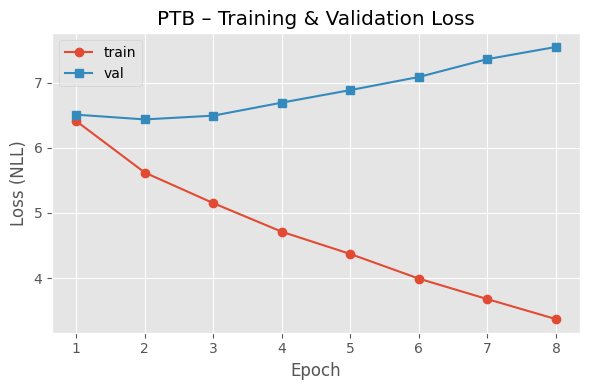

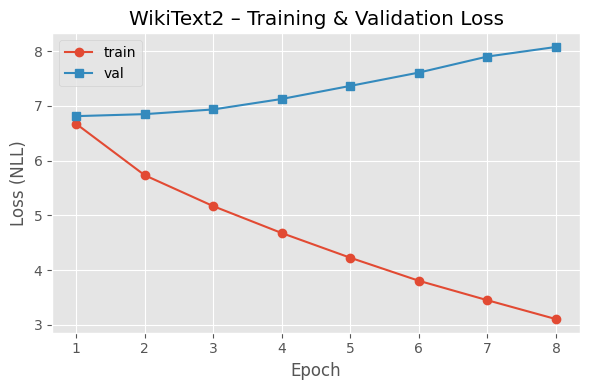

In [36]:
# %% [code]
def plot_history_and_save(hist, name):
    epochs = range(1, len(hist["train_loss"])+1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, hist["train_loss"], marker="o", label="train")
    plt.plot(epochs, hist["val_loss"], marker="s", label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLL)")
    plt.title(f"{name} – Training & Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{name.lower().replace(' ','_')}_loss.png", dpi=300)
    plt.show()

plot_history_and_save(ptb_hist, "PTB")
plot_history_and_save(wt2_hist, "WikiText2")


In [37]:
# %% [code]
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_flops(params, num_tokens, epochs):
    return 2 * params * num_tokens * epochs

ptb_params = count_params(ptb_model)
ptb_tokens = len(ptb_train_ds) * CONFIG["block_size"]
ptb_flops  = estimate_flops(ptb_params, ptb_tokens, CONFIG["epochs"])

wt2_params = count_params(wt2_model)
wt2_tokens = len(wt2_train_ds) * CONFIG["block_size"]
wt2_flops  = estimate_flops(wt2_params, wt2_tokens, CONFIG["epochs"])

print("PTB Params:", ptb_params, "FLOPs~", f"{ptb_flops:.2e}", "Test Loss:", ptb_test_loss)
print("WT2 Params:", wt2_params, "FLOPs~", f"{wt2_flops:.2e}", "Test Loss:", wt2_test_loss)


PTB Params: 2975631 FLOPs~ 2.44e+14 Test Loss: 6.189593220216313
WT2 Params: 8958077 FLOPs~ 7.33e+14 Test Loss: 6.887538936700714


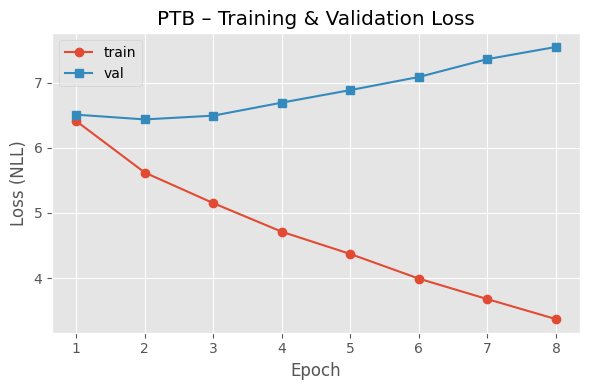

Saved ptb_loss.png


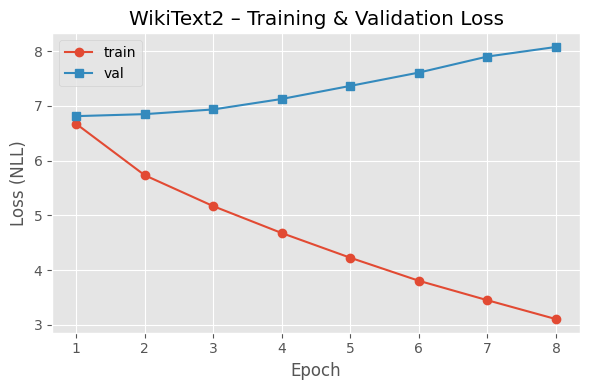

Saved wikitext2_loss.png


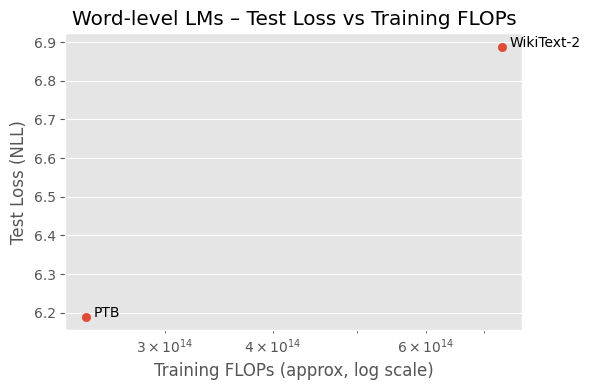

Saved wordlevel_loss_vs_flops.png


In [38]:
# %% [code]
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# 1) (Re)save PTB & WikiText-2 loss curves as separate PNGs
def plot_history_and_save(hist, name):
    epochs = range(1, len(hist["train_loss"]) + 1)
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, hist["train_loss"], marker="o", label="train")
    plt.plot(epochs, hist["val_loss"],   marker="s", label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (NLL)")
    plt.title(f"{name} – Training & Validation Loss")
    plt.legend()
    plt.tight_layout()
    fname = f"{name.lower().replace(' ', '_')}_loss.png"
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved", fname)

plot_history_and_save(ptb_hist, "PTB")
plot_history_and_save(wt2_hist, "WikiText2")

# 2) FLOPs vs Test Loss scatter for PTB vs WikiText-2
plt.figure(figsize=(6, 4))
x_vals = [ptb_flops, wt2_flops]
y_vals = [ptb_test_loss, wt2_test_loss]
labels = ["PTB", "WikiText-2"]

plt.scatter(x_vals, y_vals)
for x, y, lab in zip(x_vals, y_vals, labels):
    plt.text(x * 1.02, y, lab)

plt.xscale("log")
plt.xlabel("Training FLOPs (approx, log scale)")
plt.ylabel("Test Loss (NLL)")
plt.title("Word-level LMs – Test Loss vs Training FLOPs")
plt.tight_layout()
plt.savefig("wordlevel_loss_vs_flops.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved wordlevel_loss_vs_flops.png")


In [39]:
import math

def apply_rope(x):
    """
    x: (batch, seq, heads, head_dim)
    Applies rotary positional embeddings to queries/keys.
    """
    b, t, h, d = x.size()
    half = d // 2

    freqs = torch.arange(half, device=x.device)
    freqs = 1.0 / (10000 ** (freqs / half))

    pos = torch.arange(t, device=x.device)
    angles = torch.einsum("t,d->td", pos, freqs)  # (t, half)

    sin = angles.sin()[None, :, None, :]
    cos = angles.cos()[None, :, None, :]

    x1 = x[..., :half]
    x2 = x[..., half:]

    x_rot = torch.cat([x1 * cos - x2 * sin,
                       x1 * sin + x2 * cos], dim=-1)
    return x_rot


In [43]:
# %% [code]
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

def apply_rope(x):
    b, t, h, d = x.size()
    assert d % 2 == 0
    half = d // 2

    freqs = torch.arange(half, device=x.device, dtype=x.dtype)
    freqs = 1.0 / (10000 ** (freqs / half))
    pos = torch.arange(t, device=x.device, dtype=x.dtype)
    angles = torch.einsum("t,d->td", pos, freqs)

    sin = angles.sin()[None, :, None, :]
    cos = angles.cos()[None, :, None, :]

    x1 = x[..., :half]
    x2 = x[..., half:]

    x_rot = torch.cat([x1 * cos - x2 * sin,
                       x1 * sin + x2 * cos], dim=-1)
    return x_rot


class SwiGLUFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_model, d_ff)
        self.out = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        a = self.w1(x)
        b = self.w2(x)
        swish_b = b * torch.sigmoid(b)
        gated = a * swish_b
        return self.dropout(self.out(gated))


class RoPETransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1,
                 ffn_type="relu", pos_type="learned"):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.pos_type = pos_type

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

        if ffn_type == "relu":
            self.ff = nn.Sequential(
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Linear(d_ff, d_model),
                nn.Dropout(dropout),
            )
        elif ffn_type == "swiglu":
            self.ff = SwiGLUFFN(d_model, d_ff, dropout)
        else:
            raise ValueError(f"Unknown ffn_type={ffn_type}")

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.size()

        # --- Attention ---
        h = self.ln1(x)
        q = self.q_proj(h).view(B, T, self.n_heads, self.head_dim)
        k = self.k_proj(h).view(B, T, self.n_heads, self.head_dim)
        v = self.v_proj(h).view(B, T, self.n_heads, self.head_dim)

        if self.pos_type == "rope":
            q = apply_rope(q)
            k = apply_rope(k)

        # (B, heads, T, head_dim)
        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        att = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        att = att.masked_fill(mask, float('-inf'))
        att = torch.softmax(att, dim=-1)

        out = torch.matmul(att, v)  # (B, heads, T, head_dim)
        out = out.permute(0, 2, 1, 3).contiguous().view(B, T, C)
        out = self.out_proj(out)
        x = x + self.dropout(out)

        # --- FFN ---
        x = x + self.dropout(self.ff(self.ln2(x)))
        return x


In [44]:
# %% [code]
class RoPETransformerLM(nn.Module):
    def __init__(self, vocab_size, block_size, d_model, n_heads,
                 d_ff, n_layers, dropout=0.1,
                 ffn_type="relu", pos_type="learned"):
        super().__init__()
        self.block_size = block_size
        self.pos_type = pos_type

        self.token_emb = nn.Embedding(vocab_size, d_model)
        if pos_type == "learned":
            self.pos_emb = nn.Embedding(block_size, d_model)
        else:
            self.pos_emb = None  # RoPE doesn't need learned pos emb

        self.blocks = nn.ModuleList([
            RoPETransformerBlock(d_model, n_heads, d_ff, dropout,
                                 ffn_type=ffn_type, pos_type=pos_type)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        B, T = x.shape
        assert T <= self.block_size

        tok = self.token_emb(x)  # (B, T, C)

        if self.pos_type == "learned":
            pos = torch.arange(0, T, device=x.device)
            tok = tok + self.pos_emb(pos)[None, :, :]

        h = tok
        for blk in self.blocks:
            h = blk(h)

        h = self.ln_f(h[:, -1, :])   # last position
        logits = self.head(h)
        return logits


In [47]:
# %% [code]
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_flops(params, num_tokens, epochs):
    # same approximation you used before
    return 2 * params * num_tokens * epochs

# Number of training tokens per epoch (approx)
train_tokens_per_epoch = len(train_loader.dataset) * CONFIG["block_size"]

results_rope_vs_learned = {}

# --- Baseline: learned positional embeddings ---
print("Training Tiny Shakespeare transformer with LEARNED positions...")
ctx_len = train_loader.dataset.block_size  # <- actual context length used in data

learned_model = RoPETransformerLM(
    vocab_size=vocab_size,
    block_size=ctx_len,
    d_model=CONFIG["n_embed"],
    n_heads=CONFIG["n_heads"],
    d_ff=CONFIG["ff_hidden"],
    n_layers=CONFIG["n_layers"],
    dropout=CONFIG["dropout"],
    ffn_type="relu",
    pos_type="learned",
).to(device)

learned_model, learned_hist = train_model(
    learned_model, train_loader, val_loader,
    epochs=CONFIG["epochs"], lr=CONFIG["lr"]
)

learned_test_loss = eval_loss(learned_model, test_loader)
learned_params = count_params(learned_model)
learned_flops = estimate_flops(learned_params, train_tokens_per_epoch, CONFIG["epochs"])

results_rope_vs_learned["learned"] = {
    "hist": learned_hist,
    "test_loss": learned_test_loss,
    "params": learned_params,
    "flops": learned_flops,
}

print(f"LEARNED pos: test_loss={learned_test_loss:.4f}, params={learned_params}, FLOPs≈{learned_flops:.2e}")


# --- RoPE variant ---
print("\nTraining Tiny Shakespeare transformer with RoPE positions...")
rope_model = RoPETransformerLM(
    vocab_size=vocab_size,
    block_size=ctx_len,
    d_model=CONFIG["n_embed"],
    n_heads=CONFIG["n_heads"],
    d_ff=CONFIG["ff_hidden"],
    n_layers=CONFIG["n_layers"],
    dropout=CONFIG["dropout"],
    ffn_type="relu",
    pos_type="rope",
).to(device)

rope_model, rope_hist = train_model(
    rope_model, train_loader, val_loader,
    epochs=CONFIG["epochs"], lr=CONFIG["lr"]
)

rope_test_loss = eval_loss(rope_model, test_loader)
rope_params = count_params(rope_model)
rope_flops = estimate_flops(rope_params, train_tokens_per_epoch, CONFIG["epochs"])

results_rope_vs_learned["rope"] = {
    "hist": rope_hist,
    "test_loss": rope_test_loss,
    "params": rope_params,
    "flops": rope_flops,
}

print(f"ROPE pos: test_loss={rope_test_loss:.4f}, params={rope_params}, FLOPs≈{rope_flops:.2e}")


Training Tiny Shakespeare transformer with LEARNED positions...
Epoch 01 | train 2.6324 | val 2.3513 | time 17.1s
Epoch 02 | train 2.2648 | val 2.2077 | time 17.6s
Epoch 03 | train 2.1435 | val 2.1246 | time 17.5s
Epoch 04 | train 2.0566 | val 2.0326 | time 17.0s
Epoch 05 | train 1.9800 | val 1.9825 | time 17.0s
Epoch 06 | train 1.9286 | val 1.9238 | time 17.0s
Epoch 07 | train 1.8806 | val 1.8978 | time 17.1s
Epoch 08 | train 1.8614 | val 1.8680 | time 17.1s
LEARNED pos: test_loss=1.9738, params=430785, FLOPs≈2.21e+13

Training Tiny Shakespeare transformer with RoPE positions...
Epoch 01 | train 2.6469 | val 2.4333 | time 19.6s
Epoch 02 | train 2.3738 | val 2.2926 | time 19.5s
Epoch 03 | train 2.2589 | val 2.2202 | time 19.5s
Epoch 04 | train 2.1923 | val 2.1691 | time 19.5s
Epoch 05 | train 2.1388 | val 2.1219 | time 19.5s
Epoch 06 | train 2.0858 | val 2.0710 | time 19.5s
Epoch 07 | train 2.0360 | val 2.0396 | time 19.5s
Epoch 08 | train 1.9753 | val 1.9987 | time 19.5s
ROPE pos: tes

In [48]:
# %% [code]
def generate_chars(model, stoi, itos, prompt="HAMLET:", max_new=100):
    model.eval()
    ids = [stoi[c] for c in prompt]
    for _ in range(max_new):
        x = torch.tensor(ids[-CONFIG["block_size"]:], dtype=torch.long, device=device).unsqueeze(0)
        logits = model(x)
        probs = F.softmax(logits, dim=-1)
        idx = torch.multinomial(probs, 1).item()
        ids.append(idx)
    return "".join(itos[i] for i in ids)

print("\n=== LEARNED POS sample ===")
print(generate_chars(learned_model, stoi, itos, prompt="HAMLET:", max_new=100))

print("\n=== ROPE POS sample ===")
print(generate_chars(rope_model, stoi, itos, prompt="HAMLET:", max_new=100))



=== LEARNED POS sample ===
HAMLET:
T:
u?
OPsetetbore as gq,
Henou,-afosneanvifofapredys Gvou, Ve?ese hinoke's yefme,
Ause!
I
Ce, oue, 

=== ROPE POS sample ===
HAMLET:
Or Your my dease hat hour nother
Ibm bam pome Cleving that tood: I meart,
And tau meas cnoth anfoul


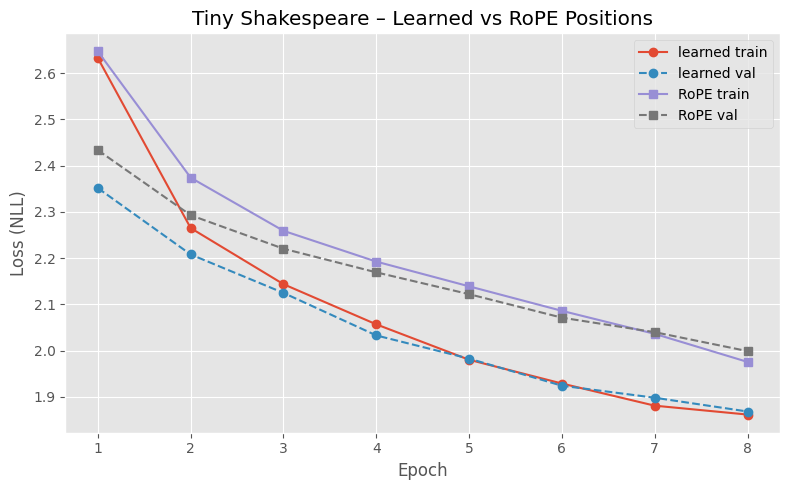

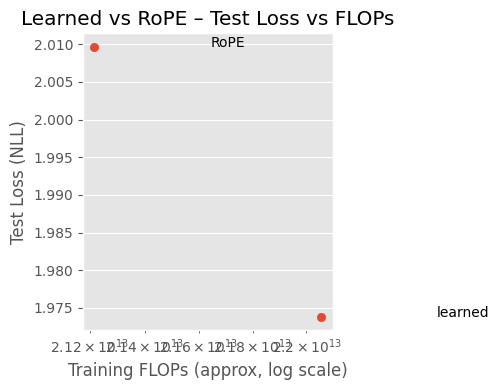

In [49]:
# %% [code]
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# 1) Training/validation curves
epochs = range(1, CONFIG["epochs"] + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, learned_hist["train_loss"], "o-", label="learned train")
plt.plot(epochs, learned_hist["val_loss"], "o--", label="learned val")
plt.plot(epochs, rope_hist["train_loss"], "s-", label="RoPE train")
plt.plot(epochs, rope_hist["val_loss"], "s--", label="RoPE val")
plt.xlabel("Epoch")
plt.ylabel("Loss (NLL)")
plt.title("Tiny Shakespeare – Learned vs RoPE Positions")
plt.legend()
plt.tight_layout()
plt.savefig("tiny_learned_vs_rope_loss.png", dpi=300, bbox_inches="tight")
plt.show()

# 2) Test loss vs FLOPs scatter
names = ["learned", "RoPE"]
flops_vals = [learned_flops, rope_flops]
test_vals  = [learned_test_loss, rope_test_loss]

plt.figure(figsize=(6, 4))
plt.scatter(flops_vals, test_vals)
for n, x, y in zip(names, flops_vals, test_vals):
    plt.text(x * 1.02, y, n)
plt.xscale("log")
plt.xlabel("Training FLOPs (approx, log scale)")
plt.ylabel("Test Loss (NLL)")
plt.title("Learned vs RoPE – Test Loss vs FLOPs")
plt.tight_layout()
plt.savefig("tiny_learned_vs_rope_flops.png", dpi=300, bbox_inches="tight")
plt.show()


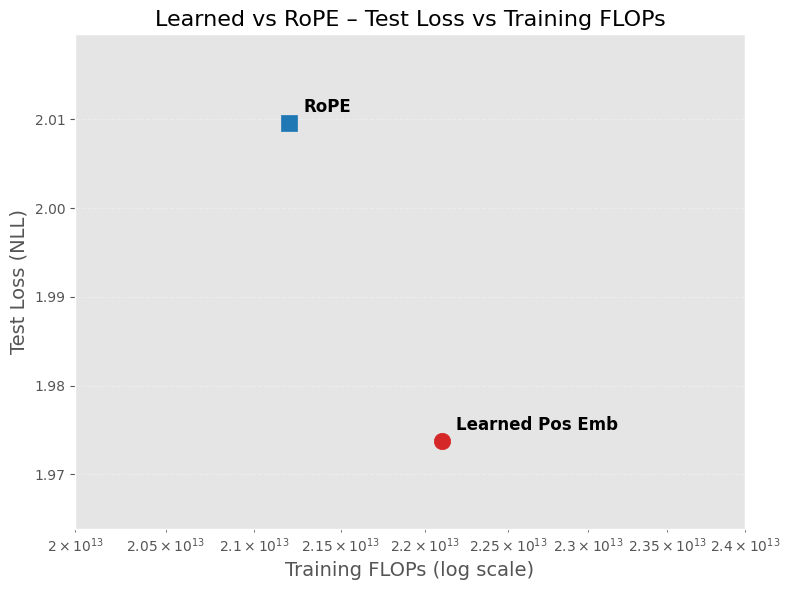

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# ===============================
# Data (replace with your actual values if different)
# ===============================
flops_learned = 2.21e13
loss_learned  = 1.9738

flops_rope = 2.12e13
loss_rope  = 2.0096

# Put into arrays
flops = np.array([flops_learned, flops_rope])
losses = np.array([loss_learned, loss_rope])
labels = ["Learned Pos Emb", "RoPE"]

colors = ["tab:red", "tab:blue"]
markers = ["o", "s"]

# ===============================
# Plot
# ===============================

plt.figure(figsize=(8,6))
plt.grid(True, linestyle="--", alpha=0.3)

# Scatter points
for i in range(len(flops)):
    plt.scatter(
        flops[i], losses[i],
        s=140, color=colors[i], marker=markers[i]
    )
    # Annotate each point with offset
    plt.annotate(
        labels[i],
        (flops[i], losses[i]),
        textcoords="offset points",
        xytext=(10, 8),
        ha='left',
        fontsize=12,
        fontweight='bold'
    )

# ===============================
# Formatting
# ===============================

plt.xscale("log")
plt.xlabel("Training FLOPs (log scale)", fontsize=14)
plt.ylabel("Test Loss (NLL)", fontsize=14)
plt.title("Learned vs RoPE – Test Loss vs Training FLOPs", fontsize=16)

# Make axis ranges tighter + consistent
plt.xlim(2.0e13, 2.4e13)
plt.ylim(min(losses)-0.01, max(losses)+0.01)

plt.tight_layout()
plt.savefig("tiny_learned_vs_rope_flops.png", dpi=300, bbox_inches="tight")
plt.show()
